In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from IPython.display import display
import time

In [23]:
start = time.time()
df = pd.read_csv("../data/text/sample21.txt", sep='\t')
df = df.set_axis(["Time", "Channel", "Signal", "Source", "Dest", "Seq", "SSID", "BSSID"], axis=1)

df["RTime"] = 0
df["Tag"] = "X"

df = df.drop(["SSID", "BSSID"], axis=1)
freq_map = {2412: 1, 2437: 6, 2462: 11}
df = df.replace({"Channel": freq_map})

for i in range(1, len(df)):
    df.loc[i, "Tag"] = str(df.loc[i - 1, "Channel"]) + "->" + str(df.loc[i, "Channel"])
    df.loc[i, "RTime"] = df.loc[i, "Time"] - df.loc[i - 1, "Time"]
    
df = df.iloc[1:, :]

df = df.astype({"Time": np.float32, "RTime": np.float32, "Signal": np.float32})

end = time.time()

In [24]:
print("Total Time: ", end - start)

Total Time:  287.59172010421753


In [25]:
display(df)

,Time,Channel,Signal,Source,Dest,Seq,RTime,Tag
1,1.667419e+09,6,-89.0,NaN,NaN,NaN,0.254872,6->6
2,1.667419e+09,1,-95.0,2a:15:c9:a0:11:d5,ff:ff:ff:ff:ff:ff,2876.0,0.275254,6->1
3,1.667419e+09,6,-85.0,NaN,ff:4d:bf:66:d9:3d,NaN,0.019067,1->6
4,1.667419e+09,11,-89.0,2a:15:c9:a0:11:d5,ff:ff:ff:ff:ff:ff,2878.0,0.026883,6->11
5,1.667419e+09,11,-83.0,72:95:90:41:02:ed,ff:ff:ff:ff:ff:ff,1253.0,0.084557,11->11
...,...,...,...,...,...,...,...,...
1836401,1.667841e+09,11,-88.0,00:22:58:70:00:dc,ff:ff:ff:ff:ff:ff,1.0,1.793032,11->11
1836402,1.667841e+09,11,-82.0,00:22:58:70:00:dc,ff:ff:ff:ff:ff:ff,2.0,0.020647,11->11
1836403,1.667841e+09,11,-90.0,00:22:58:70:00:dc,ff:ff:ff:ff:ff:ff,23.0,0.615668,11->11
1836404,1.667841e+09,11,-82.0,00:22:58:70:00:dc,ff:ff:ff:ff:ff:ff,24.0,0.020920,11->11


In [26]:
df[["RTime", "Tag"]].groupby("Tag").describe()

RTime                                                        \
           count      mean       std           min       25%       50%   
Tag                                                                      
1->1    232528.0  0.056158  0.267875  3.814697e-06  0.002227  0.015028   
1->11    66861.0  0.157663  0.547886  8.106232e-06  0.015718  0.037904   
1->6    156676.0  0.121389  0.387293  5.006790e-06  0.000019  0.026546   
11->1    86229.0  0.468836  1.181238  1.406670e-05  0.022020  0.075020   
11->11  364599.0  0.212706  0.903818  1.907349e-06  0.002858  0.020463   
11->6   164963.0  0.474344  1.209778  1.597404e-05  0.026021  0.107196   
6->1    137308.0  0.238130  0.826860  1.502037e-05  0.003457  0.031783   
6->11   184331.0  0.342241  1.008185  9.059906e-06  0.025727  0.089978   
6->6    442910.0  0.197407  0.746079  9.536743e-07  0.005188  0.020910   

                             
             75%        max  
Tag                          
1->1    0.032007  14.211750  
1->11   0.107685  24.075798  
1->6    0.125102  14.591809  
11->1   0.344901  24.214954  
11->11  0.059332  31.760733  
11->6   0.293399  30.991659  
6->1    0.100721  21.336895  
6->11   0.254784  33.225864  
6->6    0.064166  20.783031

We can see that the variances are extremely high relative to the means once again. Let's try plotting each tag as a histogram to see if they follow the power law distribution:

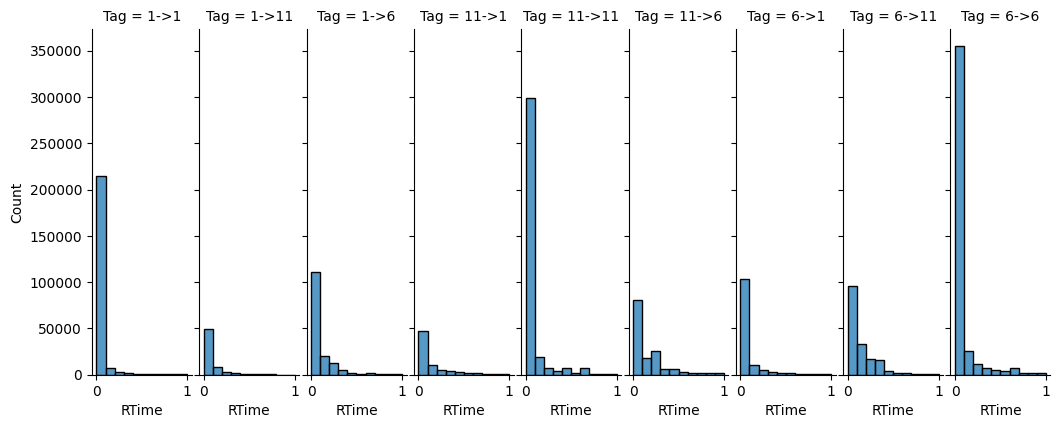

In [62]:
short = df.loc[df["RTime"] < 1, ["Tag", "RTime"]].sort_values(by="Tag")
g = sns.FacetGrid(short, col="Tag", sharey=True, sharex=True)
g.map(sns.histplot, "RTime", bins=10)
g.figure.set_size_inches(10, 5)
plt.show()

This looks like a power law distribution! First we'll check to see if each tag comes from approximately the same distribution:

In [64]:
from scipy import stats
ls = df[df.Tag == "1->1"]["RTime"]
rs1 = df[df.Tag == "6->6"]["RTime"]
rs2 = df[df.Tag == "1->6"]["RTime"]


print("1->1 vs 6->6")
x = stats.kstest(ls, rs1)
print(x)


print("1->1 vs 1->6")
print(y)
y = stats.kstest(ls, rs2)

1->1 vs 6->6
KstestResult(statistic=0.16670177547918474, pvalue=0.0)
1->1 vs 1->6
KstestResult(statistic=0.2717987955214078, pvalue=0.0)


We can see that both of the p values are 0, meaning our Tags have different distributions. At this point, it might be worthwhile to see if the interarrival times for a particular tag share the same distribution across multiple samples for the same phone. 